[1].https://www.statsmodels.org/devel/generated/statsmodels.tsa.seasonal.seasonal_decompose.html#statsmodels.tsa.seasonal.seasonal_decompose  (By Loess)

[2] https://blogs.sap.com/2020/12/21/anomaly-detection-in-time-series-using-seasonal-decomposition-in-python-machine-learning-client-for-sap-hana/   (Why we are passing the resid through the iqr test to get the accurate anomaly)

[3] https://github.com/SKawsar/time_series_analysis/blob/main/co2.ipynb

[4] https://neptune.ai/blog/anomaly-detection-in-time-series

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
import seaborn as sns
import random

In [2]:
dataset = pd.read_csv("lubridate.csv")
dataset['date'] = pd.to_datetime(dataset['date'])
display(dataset.head())
print(dataset.info())
print(dataset.describe())

,date,count,package
0,2017-01-01,643,lubridate
1,2017-01-02,1350,lubridate
2,2017-01-03,2940,lubridate
3,2017-01-04,4269,lubridate
4,2017-01-05,3724,lubridate


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     425 non-null    datetime64[ns]
 1   count    425 non-null    int64         
 2   package  425 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 10.1+ KB
None
              count
count    425.000000
mean    4582.014118
std     2397.790866
min        0.000000
25%     3063.000000
50%     4112.000000
75%     6126.000000
max    12923.000000


In [3]:
df = dataset[['date','count']].set_index('date')
display(df.head())

,count
date,
2017-01-01,643
2017-01-02,1350
2017-01-03,2940
2017-01-04,4269
2017-01-05,3724


In [4]:
def seasonal_decompose_func(df, p=None, r=None):
    stl = STL(df, period=p, robust=r)
    result = stl.fit()
    seasonal, trend, resid = result.seasonal, result.trend, result.resid
    
    plt.figure(figsize=(20,12))

    plt.subplot(4,1,1)
    plt.plot(df)
    plt.title('Original Series', fontsize=16)

    plt.subplot(4,1,2)
    plt.plot(trend)
    plt.title('Trend', fontsize=16)

    plt.subplot(4,1,3)
    plt.plot(seasonal)
    plt.title('Seasonal', fontsize=16)

    plt.subplot(4,1,4)
    plt.plot(resid)
    plt.title('Residual', fontsize=16)

    plt.tight_layout()
    
    return seasonal, trend, resid

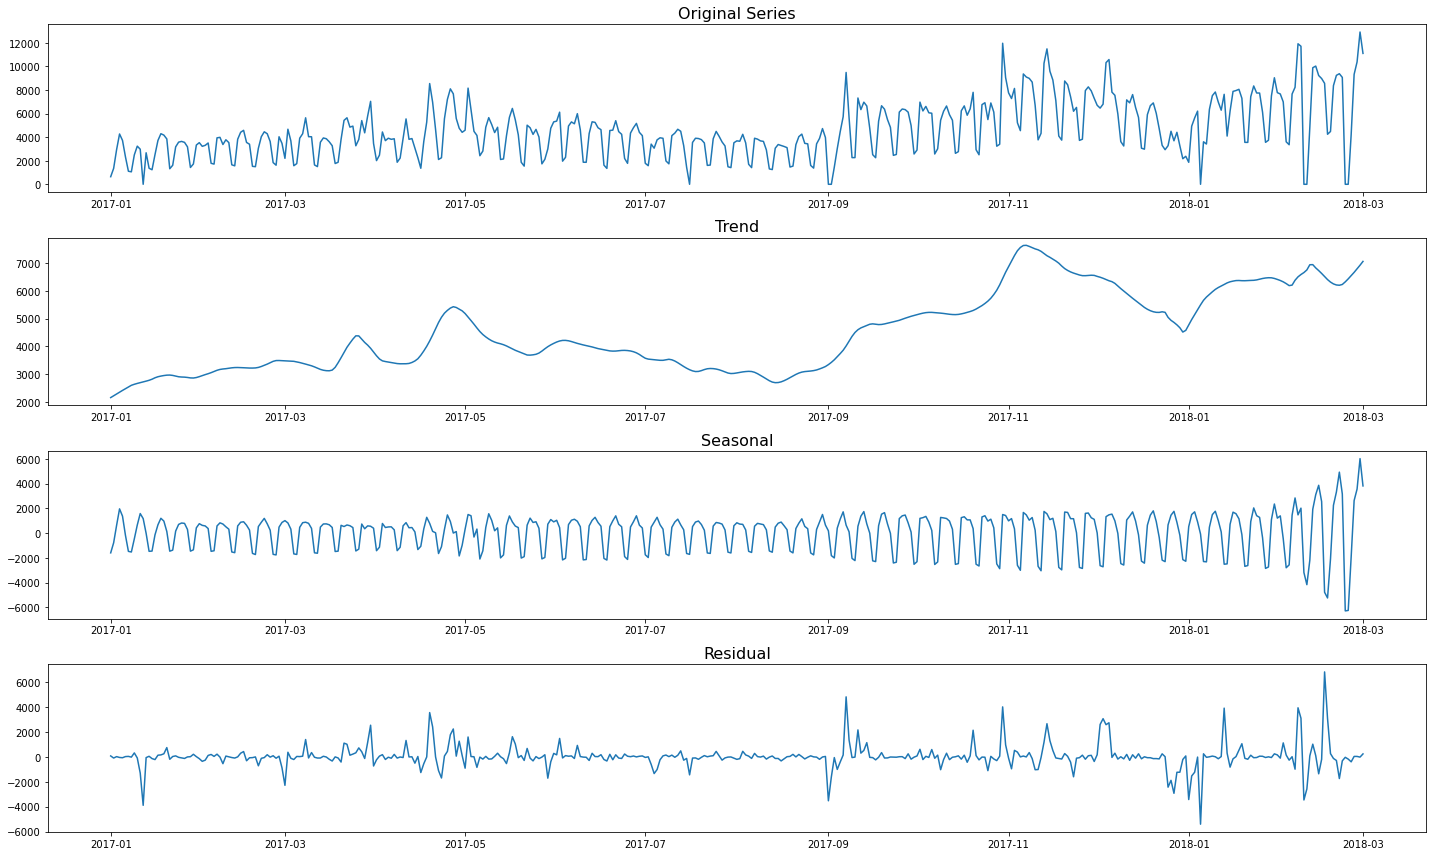

In [5]:
seasonal, trend, resid = seasonal_decompose_func(df, r= True)

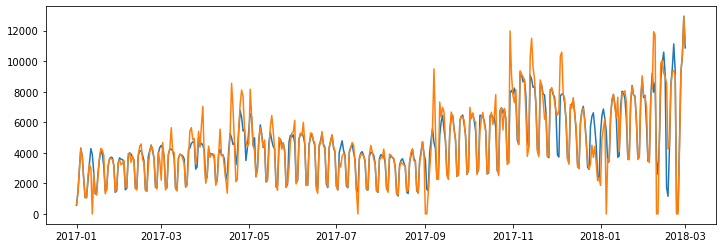

In [6]:
estimated = trend + seasonal

plt.figure(figsize=(12,4))
plt.plot(estimated.index, estimated)
plt.plot(df.index, df)
plt.show()

The orange plot shows that which data points from main column are out of the trend and seasonal datapoint

# Outlier Detection

In [7]:
resid_mu = resid.mean()
resid_dev = resid.std()

lower = resid_mu - 1.5*resid_dev
upper = resid_mu + 1.5*resid_dev

random = pd.DataFrame(resid)
anomalies = df[(resid < lower) | (resid > upper)]

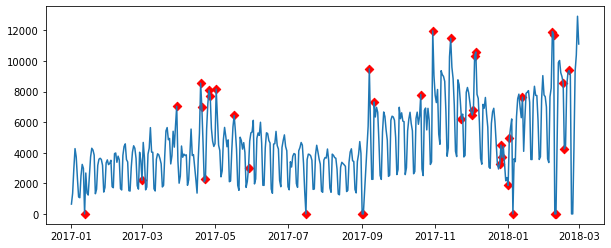

In [8]:
plt.figure(figsize=(10,4))
plt.plot(df.index, df)
  
plt.scatter(anomalies.index, anomalies, color='r', marker='D')

This data points are from main columns

------merge the residual and main column ------

In [9]:
main_residual_concat = pd.merge(random, df, left_index=True, right_index=True)

#main_residual_concat = pd.concat([random, df])
display(main_residual_concat.head())
print(main_residual_concat.info())

,resid,count
date,,
2017-01-01,82.064699,643
2017-01-02,-88.067712,1350
2017-01-03,26.168823,2940
2017-01-04,-41.927777,4269
2017-01-05,-62.769380,3724


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 425 entries, 2017-01-01 to 2018-03-01
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   resid   425 non-null    float64
 1   count   425 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 26.1 KB
None


# Outlier with IQR 

In [10]:
def IQR(df,clm):
    Q1 = np.percentile(clm, 25,
                   interpolation = 'midpoint')
 
    Q3 = np.percentile(clm, 75,
                   interpolation = 'midpoint')
    IQR = Q3 - Q1

    # Above Upper bound
    upper = clm >= (Q3+1.5*IQR)
 
    #print("Upper bound:",upper)
    upper_index = np.where(upper)
    #print("Upper index = ",np.where(upper),'\n')
 
    # Below Lower bound
    lower = clm <= (Q1-1.5*IQR)
    #print("Lower bound:", lower)
    lower_index =  np.where(lower)
    #print("Lower index ", np.where(lower),'\n')
    
    
    #Generate column for statistical z value-detected anomalies
    df['IQR_anomaly'] = "Normal"
    df.iloc[[upper_index], df.columns.get_loc('IQR_anomaly')] = "Outlier"
    df.iloc[[lower_index], df.columns.get_loc('IQR_anomaly')] = "Outlier"
    
    return upper_index, lower_index, df

-----------Outlier detect from residual--------------

In [11]:
#from residual column
upper_res, lower_res, new_df_res = IQR(main_residual_concat ,main_residual_concat['resid'])

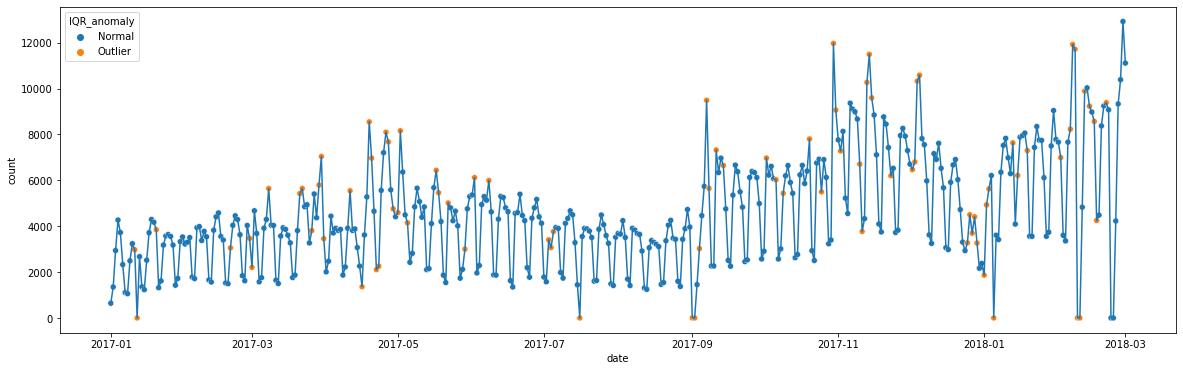

In [12]:
plt.figure(figsize=(20,6))
sns.scatterplot(data=new_df_res, x=new_df_res.index , y='count', hue="IQR_anomaly")
plt.plot(new_df_res.index, new_df_res['count'])
plt.show()

In [ ]:
#plt.figure(figsize=(20,6))
#sns.barplot(x=new_df_res.index, y='count', hue="IQR_anomaly", data=new_df_res)
#plt.show()

----------Outlier detect from main column--------

In [13]:
#from Main column where only use the IQR method
upper_main, lower_main, new_df_main = IQR(df ,df['count'])

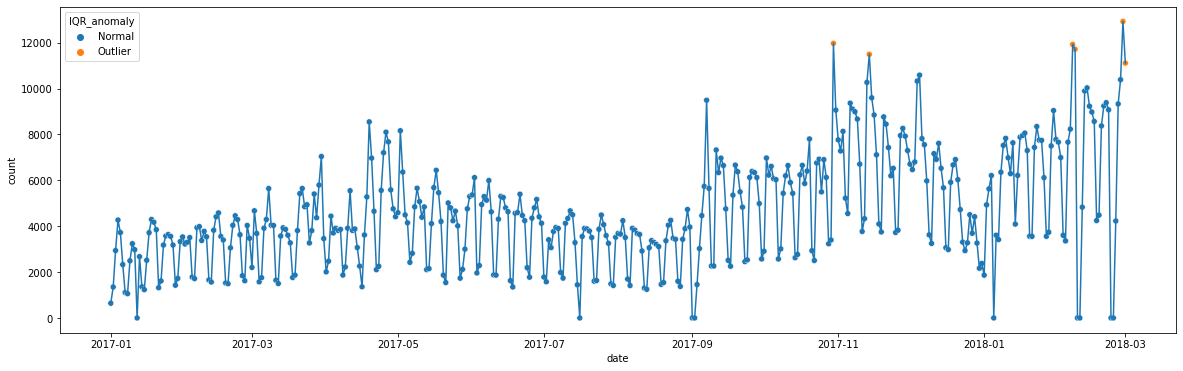

In [14]:
plt.figure(figsize=(20,6))
sns.scatterplot(data=new_df_main, x=new_df_main.index , y='count', hue="IQR_anomaly")
plt.plot(new_df_main.index, new_df_main['count'])
plt.show()

# Test with single column

In [15]:
df_single_column = pd.read_csv("lubridate.csv")
df['date'] = pd.to_datetime(df_single_column['date'])
only_count = df_single_column['count']
only_count = pd.DataFrame(only_count)
only_count

,count
0,643
1,1350
2,2940
3,4269
4,3724
...,...
420,4228
421,9329
422,10386
423,12923


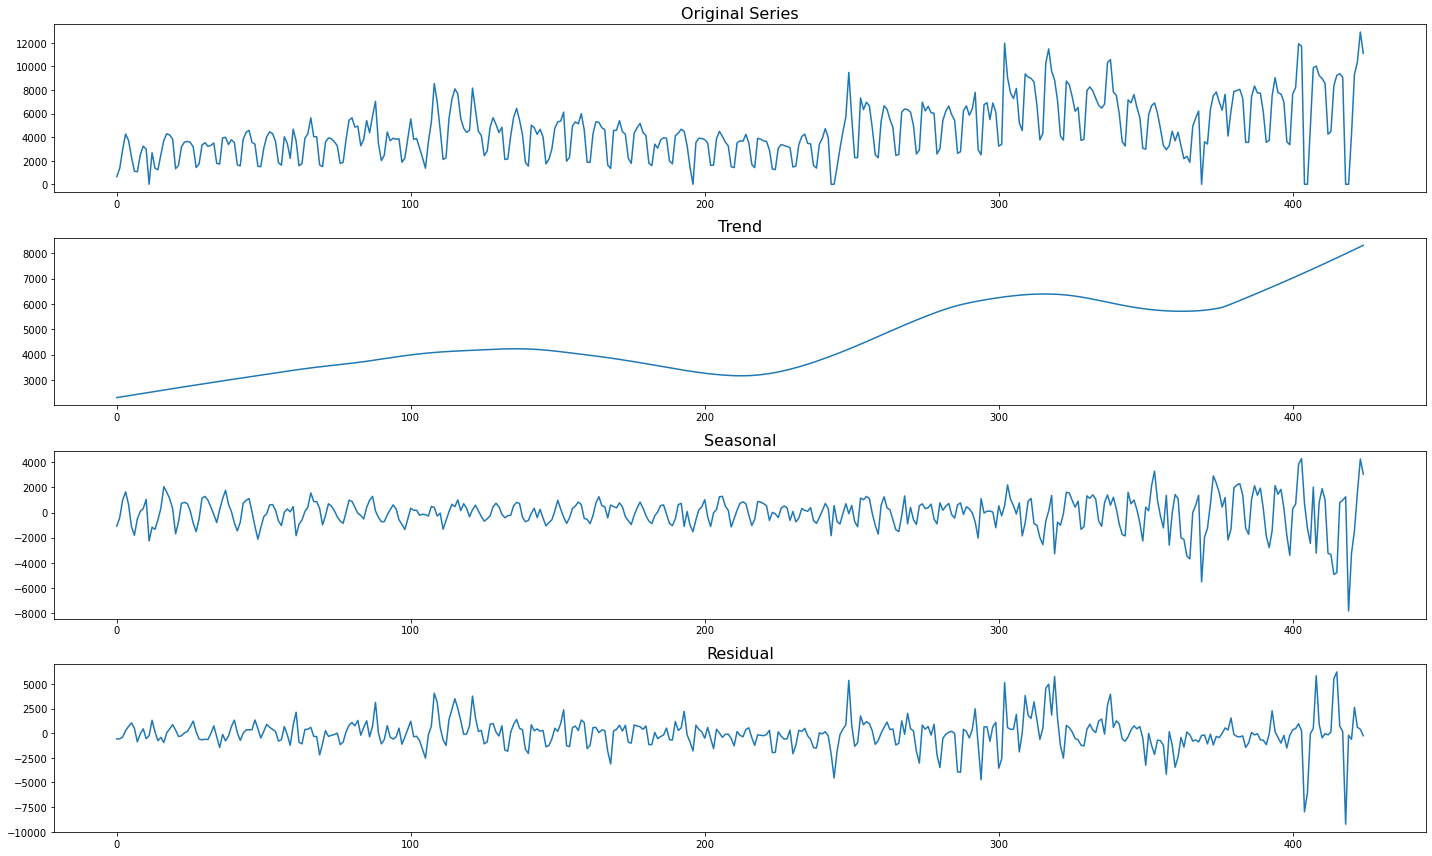

In [16]:
# For single column, need to mention the period
seasonal, trend, resid = seasonal_decompose_func(only_count, p=50 ,r= True)

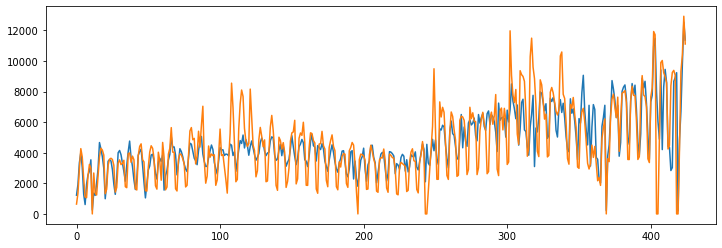

In [17]:
estimated = trend + seasonal

plt.figure(figsize=(12,4))
plt.plot(estimated.index, estimated)
plt.plot(only_count)
plt.show()

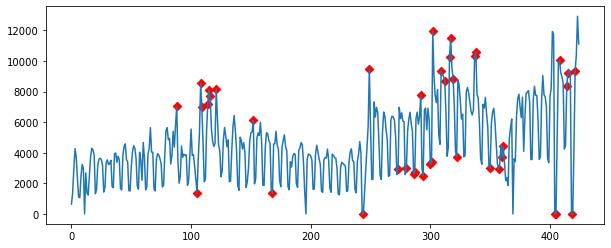

In [18]:
resid_mu = resid.mean()
resid_dev = resid.std()

lower = resid_mu - 1.5*resid_dev
upper = resid_mu + 1.5*resid_dev

random = pd.DataFrame(resid)
anomalies = only_count[(resid < lower) | (resid > upper)]

plt.figure(figsize=(10,4))
plt.plot(only_count.index, only_count)
  
plt.scatter(anomalies.index, anomalies, color='r', marker='D')

This anomalies are almost same when we try with the date column. 

-------Outlier detection with residual-------

In [19]:
main_residual_concat_for_single_column = pd.merge(random, only_count, left_index=True, right_index=True)

#main_residual_concat = pd.concat([random, df])
display(main_residual_concat_for_single_column.head())
print(main_residual_concat_for_single_column.info())

,resid,count
0,-580.141102,643
1,-574.028570,1350
2,-396.431474,2940
3,261.189449,4269
4,683.709551,3724


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   resid   425 non-null    float64
 1   count   425 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 6.8 KB
None


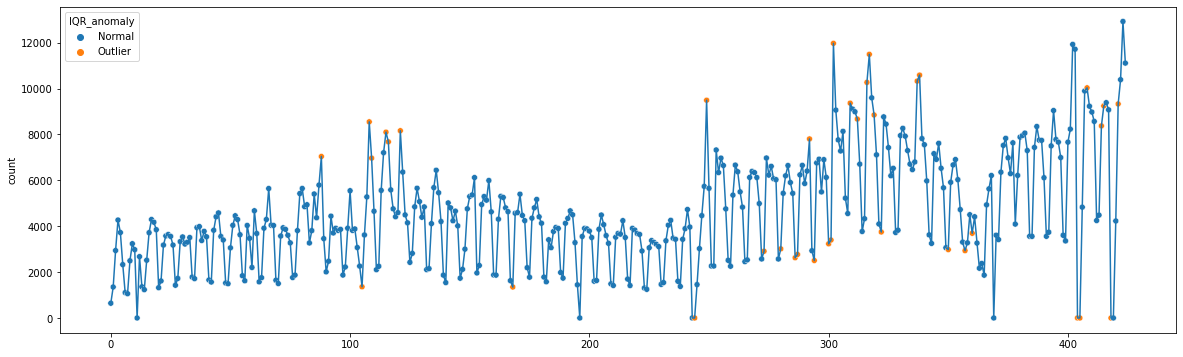

In [20]:
upper_res, lower_res, new_df_res = IQR(main_residual_concat_for_single_column ,main_residual_concat_for_single_column['resid'])

plt.figure(figsize=(20,6))
sns.scatterplot(data=main_residual_concat_for_single_column, x=main_residual_concat_for_single_column.index , y='count', hue="IQR_anomaly")
plt.plot(main_residual_concat_for_single_column.index, main_residual_concat_for_single_column['count'])
plt.show()

-------Outlier detection with with main column through IQR-------

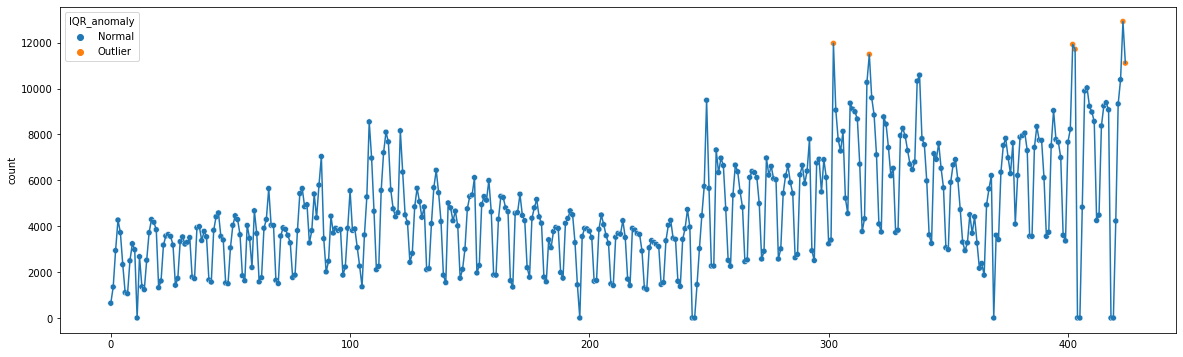

In [21]:
#from Main column
#use only IQR
upper_main, lower_main, new_df_main = IQR(only_count ,only_count['count'])

plt.figure(figsize=(20,6))
sns.scatterplot(data=new_df_main, x=new_df_main.index , y='count', hue="IQR_anomaly")
plt.plot(new_df_main.index, new_df_main['count'])
plt.show()